# Extracting and processing STM Image Data from Omicron's propritary .Z_MTRX format 
In order to extract the images, first import the necessary packages. We will be using NanoscoPy to read the STM data and matplotlib to show the data.

In [2]:
import matplotlib.pyplot as plt
from pathlib import Path

In [1]:
# Custom modules
# import sys
# sys.path.append('../../NanoscoPy/')
from nanoscopy import spm
from nanoscopy.utilities import dialog_askdirectory 

### Get Root Folder Path
Prompt the user for the directory which contains the .Z_mtrx files and the result file chain.

In [3]:
folder_path = dialog_askdirectory()

### Read all STM files in the folder

In [4]:
scans = spm.read(folder_path)

Reading 4 mtrx files...DONE


### Correct the forward sweep data
Each image is globally flattened via plane correction, followed by 2nd order polynomial background subtraction, line-by-line offset flattening, 3x3 gaussian smoothing, and CLAHE.

In [5]:
corrected_scans = spm.correct([spm_data.dataframe['image'].iloc[0] for spm_data in scans])

C:\Users\Darian\miniconda3\lib\site-packages\spiepy\flatten.py:54: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, _, _, _ = np.linalg.lstsq(g, z)


 Corrcting images...Done ########## [100.00%]

### Show a comparison plot between some of the raw and processed images

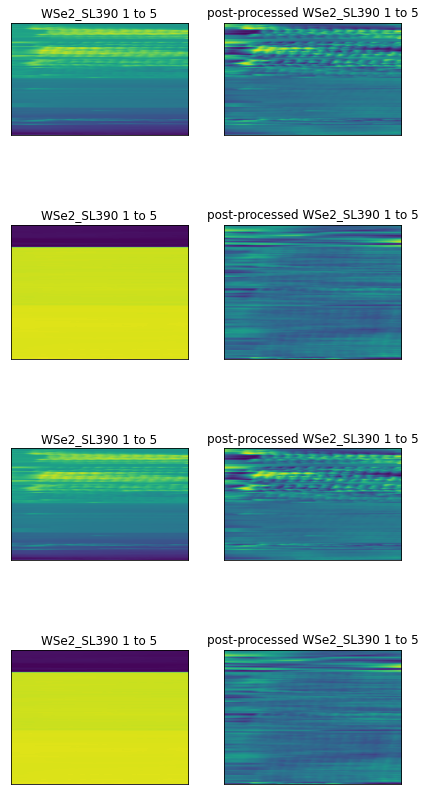

In [6]:
n = len(corrected_scans)
fig, axs = plt.subplots(n, 2)
fig.set_figheight(15)
fig.set_figwidth(7)
for i in range(n):
    raw = scans[i]
    processed = corrected_scans[i]
    sample_name = f'{raw.dataframe["sample_id"].iloc[0]}'

    axs[i, 0].imshow(raw.dataframe['image'].iloc[0] , origin = 'lower')
    axs[i, 0].set_title(sample_name)
    axs[i, 1].imshow(processed , origin = 'lower')
    axs[i, 1].set_title(f'post-processed {sample_name}')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

### Output directories 

In [7]:
dst_paths = [f'{Path(scan.dataframe["path"].iloc[0]).parent}\\{scan.summary()}.jpg' for scan in scans]
dst_paths

['C:\\Users\\Darian\\Downloads\\hone group WSe2 data\\WSe2\\SL390 1 to 5\\2021-09-14\\WSe2_SL390 1 to 5_210914_-2.2V_5x5_1_1_Z.jpg',
 'C:\\Users\\Darian\\Downloads\\hone group WSe2 data\\WSe2\\SL390 1 to 5\\2021-09-14\\WSe2_SL390 1 to 5_210914_-2.0V_2x2_2_1_Z.jpg',
 'C:\\Users\\Darian\\Downloads\\hone group WSe2 data\\WSe2\\SL390 1 to 5\\2021-09-15\\WSe2_SL390 1 to 5_210915_-2.2V_5x5_1_1_Z.jpg',
 'C:\\Users\\Darian\\Downloads\\hone group WSe2 data\\WSe2\\SL390 1 to 5\\2021-09-15\\WSe2_SL390 1 to 5_210915_-2.0V_2x2_2_1_Z.jpg']

### Export the data as jpg

In [ ]:
spm.io.export_images(corrected_scans, dst_paths)

### Export metadata as csv 

In [ ]:
spm.io.export_metadata(scans, folder_path)